In [1]:
import ipaddress
import json
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict
from datetime import datetime, timedelta
import numpy as np
from pathlib import Path
from collections import Counter
import ast
import matplotlib.colors as mcolors
import maxminddb
from itertools import combinations

In [2]:
def ip_to_subnet(ip):
   try:
       return str(ipaddress.IPv4Network(f"{ip}/24", strict=False).network_address) + "/24"
   except:
       return None

def ip_to_asn(ip_address, db_path='data/external/GeoLite2-ASN.mmdb'):
    try:
        with maxminddb.open_database(db_path) as reader:
            result = reader.get(ip_address)
            return result['autonomous_system_organization']
    except Exception as e:
        return None
   
def set_plt_latex_format():
    plt.rcParams.update({
        "font.size": 12,          # Base font size
        "axes.titlesize": 12,     # Title size
        "axes.labelsize": 10,     # Axis label size
        "xtick.labelsize": 10,    # X-tick label size
        "ytick.labelsize": 10,    # Y-tick label size
        "legend.fontsize": 12,    # Legend font size
        "figure.titlesize": 12,    # Figure title size
        "text.usetex": True,
        "font.family": "serif",
        "font.serif": ["Computer Modern Roman"]
    })

def retrieve_color_palette(n_colors=10, blends=None):
    if blends is None or len(blends) < 2:
        blends = ['#c40d1e', '#9013fe']  # Default red to purple
    
    # Convert all hex colors to RGB
    rgb_colors = [np.array(mcolors.hex2color(color)) for color in blends]
    
    # Calculate how many segments we need
    segments = len(blends) - 1
    colors_per_segment = n_colors // segments
    extra_colors = n_colors % segments  # Distribute remainder colors among segments
    
    # Create the color list
    colors = []
    
    for i in range(segments):
        start_color = rgb_colors[i]
        end_color = rgb_colors[i+1]
        
        # Calculate how many colors for this segment (distribute remainder)
        segment_colors = colors_per_segment + (1 if i < extra_colors else 0)
        
        # Create colors for this segment
        for j in range(segment_colors):
            if segment_colors > 1:  # Avoid division by zero
                t = j / (segment_colors - 1)
            else:
                t = 0
            color = tuple(start_color + (end_color - start_color) * t)
            colors.append(color)
    
    # Create matplotlib colormap and seaborn palette
    custom_cmap = mcolors.ListedColormap(colors)
    #custom_palette = sns.color_palette(colors, n_colors=len(colors))
    
    return colors, custom_cmap#, custom_palette

In [3]:
def load_json(folder_path):
    # load all jsons
    all_packets = []
    all_peers = []

    for json_file in folder_path.glob("*.json"):
       with open(json_file, 'r') as f:
           data = json.load(f)
    
       for packet in data['packets']:
            packet_meta = {k: v for k, v in packet.items() if not k in ['local_peerlist_new', 'node_data', 'payload_data']}

            if not packet['node_data'] is None:
                for k, v in packet['node_data'].items():
                    packet_meta[k] = v
            if not packet['payload_data'] is None:
                for k, v in packet['payload_data'].items(): 
                    packet_meta[k] = v

            if not packet['local_peerlist_new'] is None:
                packet['peerlist_length'] = len(packet['local_peerlist_new'])
                for peer in packet['local_peerlist_new']:
                    peer_data = peer.copy()
                    peer_data['source_ip'] = packet['source_ip']
                    peer_data['timestamp'] = packet['timestamp']
                    peer_data['pl_identifier'] = packet['timestamp'] + '_' + packet['source_ip']
                    all_peers.append(peer_data)

            all_packets.append(packet_meta)

    return pd.DataFrame(all_packets), pd.DataFrame(all_peers)

folder_path=Path("data/packets/blr")
node = str.split(str(folder_path), '/')[-1]

peer_packets_df, peers_df = load_json(folder_path=folder_path)
# some data cleaning
possible_flags = ['1', '2', '1,2', '2,1', '1,1']
peer_packets_df = peer_packets_df[peer_packets_df['monero_flags'].isin(possible_flags)]
peer_packets_df['timestamp'] = pd.to_datetime(peer_packets_df['timestamp'])


In [4]:
def create_result_df(peer_packets_df):
    grouped = peer_packets_df.groupby('source_ip')

    result_df = pd.DataFrame()

    result_df['source_ip'] = grouped['source_ip'].first()
    result_df['packet_count'] = grouped.size()
    result_df['unique_commands'] = grouped['command'].nunique()
    result_df['my_ports'] = grouped['my_port'].apply(lambda x: x.dropna().astype(int).unique().tolist())
    result_df['unique_my_ports'] = grouped['my_port'].nunique()
    result_df['rpc_ports'] = grouped['rpc_port'].apply(lambda x: x.dropna().astype(int).unique().tolist())
    result_df['unique_rpc_ports'] = grouped['rpc_port'].nunique()
    result_df['peer_ids'] = grouped['peer_id'].apply(lambda x: x.dropna().unique().tolist())
    result_df['unique_peer_ids'] = grouped['peer_id'].nunique()
    result_df['has_support_flags'] = grouped['support_flags'].apply(lambda x: x.notna().any())
    result_df['unique_source_ports'] = grouped['source_port'].nunique()

    return pd.DataFrame(result_df)

result_df = create_result_df(peer_packets_df)
quantiles = [0.5, 0.75, 0.9, 0.99]
stats = ['packet_count', 'unique_my_ports', 'unique_peer_ids', 'unique_source_ports', 'unique_rpc_ports']
#print(result_df.head())
print("-"*50)
print(f"Basic stats based on IP")
print("-"*50)
for s in stats:
    print('-'*50)
    print(f"Distribution for {s}")
    print('-'*50)
    for q in quantiles:
        print(f"{q}th: {result_df[s].quantile(q)}")
    print(f"Max: {result_df[s].max()}")

--------------------------------------------------
Basic stats based on IP
--------------------------------------------------
--------------------------------------------------
Distribution for packet_count
--------------------------------------------------
0.5th: 10.0
0.75th: 130.0
0.9th: 369.39999999999964
0.99th: 2800.539999999999
Max: 39684
--------------------------------------------------
Distribution for unique_my_ports
--------------------------------------------------
0.5th: 1.0
0.75th: 1.0
0.9th: 1.0
0.99th: 3.0
Max: 114
--------------------------------------------------
Distribution for unique_peer_ids
--------------------------------------------------
0.5th: 1.0
0.75th: 1.0
0.9th: 1.0
0.99th: 5.0
Max: 20133
--------------------------------------------------
Distribution for unique_source_ports
--------------------------------------------------
0.5th: 1.0
0.75th: 2.0
0.9th: 3.0
0.99th: 8.769999999999527
Max: 17353
--------------------------------------------------
Distributi

In [5]:
# quick check grouped by peer_id, only relevant for exploration
def create_peer_id_df(peer_packets_df):
    grouped = peer_packets_df.groupby('peer_id')

    result_df = pd.DataFrame()

    result_df['peer_id'] = grouped['peer_id'].first()

    result_df['source_ips'] = grouped['source_ip'].apply(lambda x: x.dropna().unique().tolist())
    result_df['unique_source_ips'] = grouped['source_ip'].nunique()

    return pd.DataFrame(result_df)

peer_id_df = create_peer_id_df(peer_packets_df)
quantiles = [0.5, 0.75, 0.9, 0.999]
stats = ['unique_source_ips']
print("-"*50)
print(f"Basic stats based on Peer ID")
print("-"*50)
for s in stats:
    print('-'*50)
    print(f"Percentile distribution for {s}")
    print('-'*50)
    for q in quantiles:
        print(f"{q}th: {peer_id_df[s].quantile(q)}")
    print(f"Max: {peer_id_df['unique_source_ips'].max()}")

#for _, row in peer_id_df.iterrows():
#    if row['unique_source_ips'] > 2:
#        print(row)

--------------------------------------------------
Basic stats based on Peer ID
--------------------------------------------------
--------------------------------------------------
Percentile distribution for unique_source_ips
--------------------------------------------------
0.5th: 1.0
0.75th: 1.0
0.9th: 1.0
0.999th: 2.0
Max: 465


In [6]:
# quick clustering to find shared peer ids among distinct IPs 
def add_peer_id_clusters(result_df, node):
   from collections import defaultdict
   
   # Build graph of connections
   graph = defaultdict(set)
   for _, row in result_df.iterrows():
       ip = row['source_ip']
       for peer_id in row['peer_ids']:
           graph[ip].add(peer_id)
           graph[peer_id].add(ip)
   
   # Find connected components using stack
   visited = set()
   clusters = []
   
   for start_node in graph:
       if start_node in visited:
           continue
           
       cluster = set()
       stack = [start_node]
       
       while stack:
           current_node = stack.pop()
           if node in visited:
               continue
           visited.add(current_node)
           cluster.add(current_node)
           stack.extend(graph[current_node] - visited)
       
       clusters.append(cluster)
   
   # Map IPs to cluster IDs
   ip_to_cluster = {}
   for i, cluster in enumerate(clusters):
       for current_node in cluster:
           if current_node in result_df['source_ip'].values:
               ip_to_cluster[current_node] = i
   
   # Add cluster column
   result_df = result_df.copy()
   result_df[f'peer_id_cluster_{node}'] = result_df['source_ip'].map(ip_to_cluster)
   return result_df

result_df = add_peer_id_clusters(result_df, node)

--------------------------------------------------
Average connection duration: 0 days 00:08:02.018972187
--------------------------------------------------
Peer's Avg Timed Sync Frequency Analysis:
--------------------------------------------------
Averaged over 6224 individual connections: 67.99890512737406
Max: 628.0229926058392
Percentile distribution: 
    0.5th percentile: 62.25145070238095
    0.75th percentile: 63.48814429619565
    0.9th percentile: 79.3953176832861
    0.95th percentile: 95.43787024221481
    0.99th percentile: 142.78840731733328


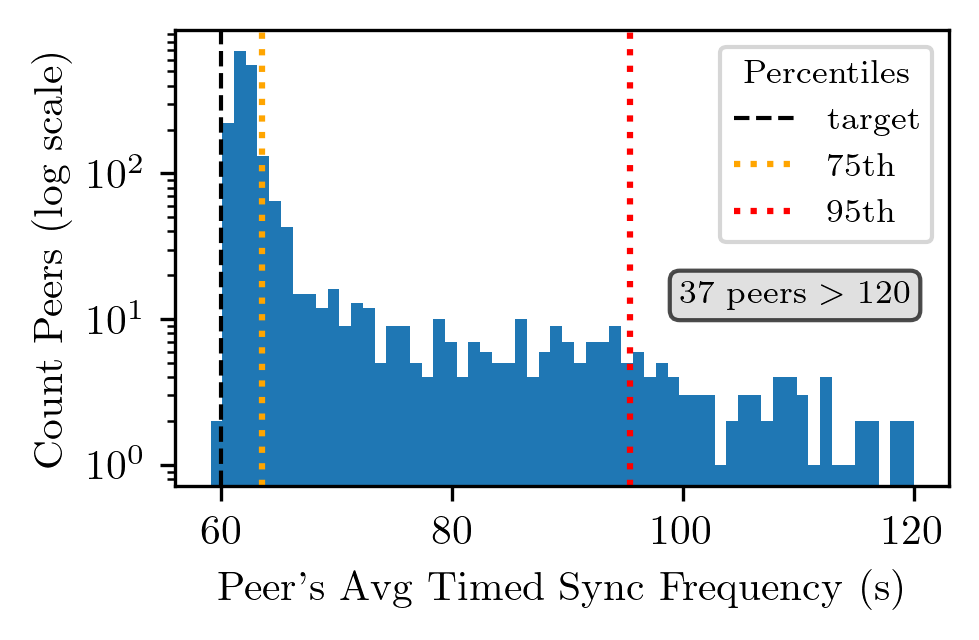

--------------------------------------------------
Connection's Avg Timed Sync Frequency Analysis:
--------------------------------------------------
20263 individual connections: 68.17565811600056
Max: 628.0229926058392
Percentile distribution: 
    0.5th percentile: 62.19914859892474
    0.75th percentile: 63.53936615625
    0.9th percentile: 81.65379136863447
    0.95th percentile: 96.91542328853303
    0.99th percentile: 142.55469698133305


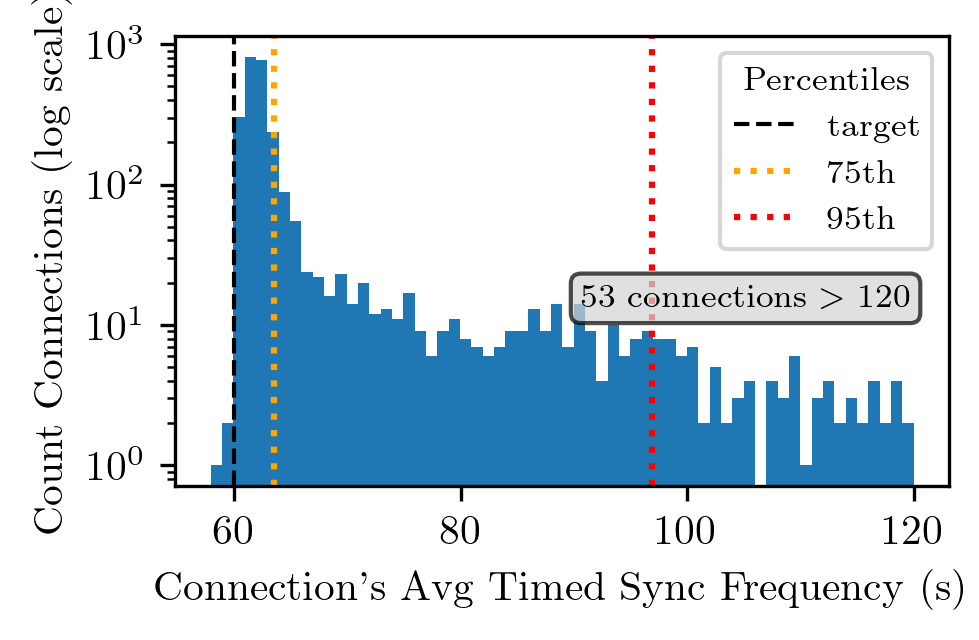

In [7]:
def analyze_ts_latency(peer_packets_df, result_df):
    all_data = peer_packets_df.copy()
    all_data = all_data.sort_values(['source_ip', 'source_port', 'timestamp'])

    all_data['source_endpoint'] = all_data['source_ip'].astype(str) + ':' + all_data['source_port'].astype(str)
    all_data['source_endpoint_cat'] = all_data['source_endpoint'].astype('category')

    # shift to later compare current vs prev IP
    all_data['prev_endpoint'] = all_data['source_endpoint_cat'].shift(1)
    all_data['time_diff'] = all_data['timestamp'].diff().dt.total_seconds()

    # mask logic to identify breaks if IP changes, time is bigger 120s (idle), first row, handshake
    all_data['is_break'] = (
        (all_data['source_endpoint_cat'] != all_data['prev_endpoint']) |
        (all_data['time_diff'] > 120) |
        (all_data['time_diff'].isna()) |
        (all_data['command'] == '1001')
    )
    
    all_data['connection_id'] = all_data['is_break'].cumsum()

    # filter already for valid conns
    grouped = all_data.groupby('connection_id')
    connection_sizes = grouped.size()
    valid_conns = connection_sizes >= 2
    valid_conn_ids = valid_conns[valid_conns].index

    all_ts_diffs = []
    conn_info = []

    for conn_id in valid_conn_ids:
        conn = grouped.get_group(conn_id)
        commands = np.array(conn['command'])
        monero_flags = np.array(conn['monero_flags'])
        timestamps = np.array(conn['timestamp'])
        if len(commands) > 1: 
            duration = timestamps[-1]-timestamps[0]
        else:
            duration = None
        ts_mask = (commands == '1002') & (monero_flags == '1')
        ts_series = pd.Series(timestamps[ts_mask])
        
        # Get source IP for this connection
        source_ip = conn['source_ip'].iloc[0]

        if len(ts_series) > 2:
            differences = ts_series.diff().dt.total_seconds().dropna()
            all_ts_diffs.extend(differences)
            latency = differences.mean()

            # Append connection info for efficient processing
            conn_info.append({'source_ip': source_ip, 'ts_latency': latency, 'duration': duration})
        else:
            # If no valid latency, still record the IP with None
            conn_info.append({'source_ip': source_ip, 'ts_latency': None, 'duration': duration})

    conn_df = pd.DataFrame(conn_info)

    latency_by_ip = conn_df.groupby('source_ip')['ts_latency'].mean()

    result_df['ts_latency'] = result_df['source_ip'].map(latency_by_ip)
    
    quantiles = [0.50, 0.75, 0.90, 0.95, 0.99]
    print('-'*50)
    print(f"Average connection duration: {conn_df['duration'].mean()}")
    print(f"-"*50)
    print(f"Peer\'s Avg Timed Sync Frequency Analysis:")
    print(f"-"*50)
    print(f"Averaged over {len(result_df['ts_latency'])} individual connections: {np.mean(result_df['ts_latency'])}")
    print(f"Max: {result_df['ts_latency'].max()}")
    print(f"Percentile distribution: ")
    for quantile in quantiles:
        print(f"    {quantile}th percentile: {result_df['ts_latency'].quantile(quantile)}")

    set_plt_latex_format()
    plt.figure(figsize=(3.13, 2), dpi=300)
    plt.hist(result_df['ts_latency'], range=(result_df['ts_latency'].min(), 120), bins=int(120-result_df['ts_latency'].min()), log=True)
    #plt.axvline(result_df['ts_latency'].quantile(0.5), color='orange', linestyle='--', label='50th')
    plt.axvline(60, color='black', linestyle='--', label='target', linewidth=1)
    plt.axvline(result_df['ts_latency'].quantile(0.75), color='orange', linestyle=':', label='75th')
    plt.axvline(result_df['ts_latency'].quantile(0.95), color='red', linestyle=':', label='95th')
    outlier_count = sum(x > 120 for x in result_df['ts_latency'])
    plt.text(0.95, 0.45, f'{outlier_count} peers $>$ 120', fontsize=8,
             transform=plt.gca().transAxes, ha='right', va='top',
             bbox=dict(boxstyle='round,pad=0.3', facecolor='lightgray', alpha=0.7))
    plt.xlabel(f'Peer\'s Avg Timed Sync Frequency (s)')
    plt.xticks([60,80,100,120])
    plt.ylabel(f'Count Peers (log scale)')
    plt.legend(title='Percentiles', fontsize=8, title_fontsize=8)
    plt.tight_layout(pad=0.2)
    #plt.savefig('results/graphs/ts_latency_dist.pdf')
    plt.show()

    print(f"-"*50)
    print(f"Connection\'s Avg Timed Sync Frequency Analysis:")
    print(f"-"*50)
    print(f"{len(conn_df['ts_latency'])} individual connections: {np.mean(conn_df['ts_latency'])}")
    print(f"Max: {conn_df['ts_latency'].max()}")
    print(f"Percentile distribution: ")
    for quantile in quantiles:
        print(f"    {quantile}th percentile: {conn_df['ts_latency'].quantile(quantile)}")
    plt.figure(figsize=(3.13, 2), dpi=300)
    plt.hist(conn_df['ts_latency'], range=(conn_df['ts_latency'].min(), 120), bins=int(120-conn_df['ts_latency'].min()), log=True)
    #plt.axvline(result_df['ts_latency'].quantile(0.5), color='orange', linestyle='--', label='50th')
    plt.axvline(60, color='black', linestyle='--', label='target', linewidth=1)
    plt.axvline(conn_df['ts_latency'].quantile(0.75), color='orange', linestyle=':', label='75th')
    plt.axvline(conn_df['ts_latency'].quantile(0.95), color='red', linestyle=':', label='95th')
    outlier_count = sum(x > 120 for x in conn_df['ts_latency'])
    plt.text(0.95, 0.45, f'{outlier_count} connections $>$ 120', fontsize=8,
             transform=plt.gca().transAxes, ha='right', va='top',
             bbox=dict(boxstyle='round,pad=0.3', facecolor='lightgray', alpha=0.7))
    plt.xlabel(f'Connection\'s Avg Timed Sync Frequency (s)')
    plt.xticks([60,80,100,120])
    plt.ylabel(f'Count Connections (log scale)')
    plt.legend(title='Percentiles', fontsize=8, title_fontsize=8)
    plt.tight_layout(pad=0.2)
    #plt.savefig('results/graphs/ts_latency_dist.pdf')
    plt.show()
    
    
    return result_df

result_df = analyze_ts_latency(peer_packets_df, result_df)


In [8]:
high_lat = result_df[result_df['ts_latency'] > 120]
#print(high_lat)


Ping Analysis:
32983 connections.
Percentile distribution of number of Pings sent per connection: 
    0.5th percentile: 1.0
    0.75th percentile: 1.0
    0.9th percentile: 1.0
    0.95th percentile: 1.0
    0.99th percentile: 28.0
Percentile distribution of frequency of Pings if more than one is sent: 
    0.5th percentile: 6.07677185185185
    0.75th percentile: 6.156730788461539
    0.9th percentile: 8.073864150746271
    0.95th percentile: 10.09457264447439
    0.99th percentile: 51.52145067999989


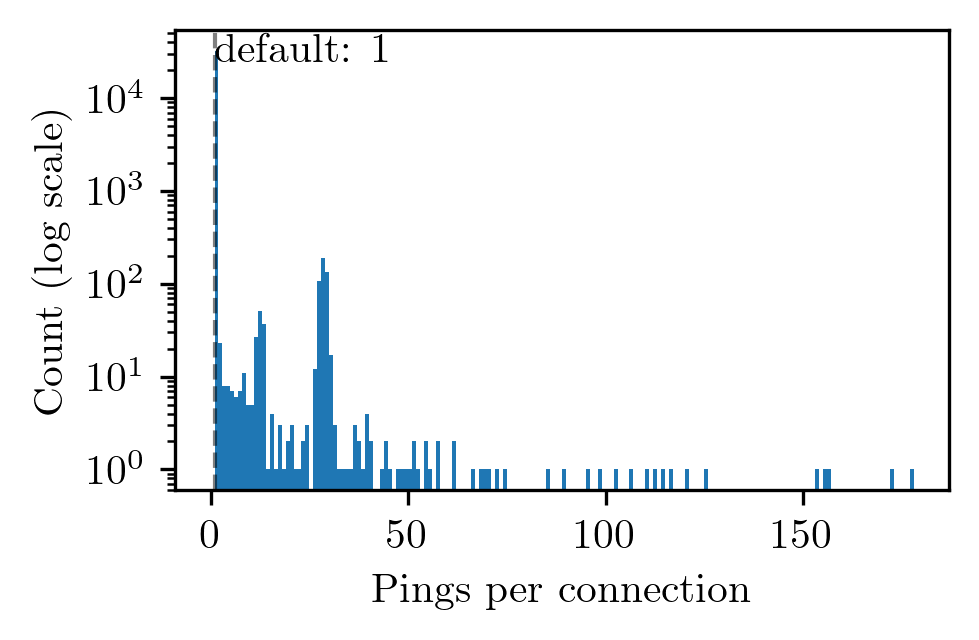

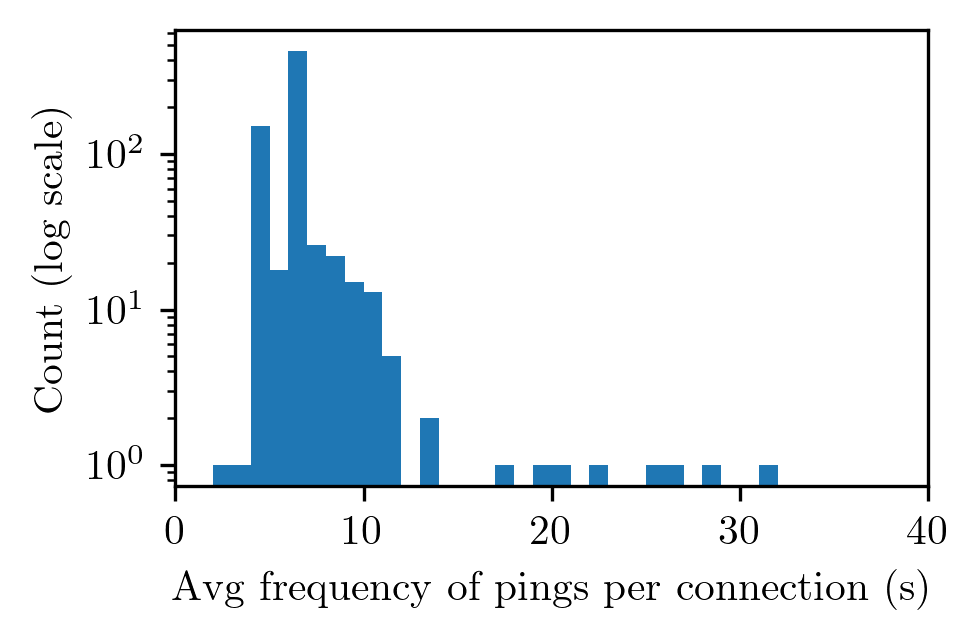

In [54]:
def analyze_ping_connections(peer_packets_df, result_df):
    # for connection visualization stick to IP and dont split the connection for repeated Handshakes (known pattern)
    all_data = peer_packets_df.copy()
    all_data = all_data.sort_values(['source_ip', 'source_port', 'timestamp'])

    all_data['source_endpoint'] = all_data['source_ip'].astype(str) + ':' + all_data['source_port'].astype(str)
    all_data['source_endpoint_cat'] = all_data['source_endpoint'].astype('category')

    # shift to later compare current vs prev IP
    all_data['prev_endpoint'] = all_data['source_endpoint_cat'].shift(1)
    all_data['time_diff'] = all_data['timestamp'].diff().dt.total_seconds()

    # mask logic to identify breaks if IP changes, time is bigger 120s (idle), first row, handshake
    all_data['is_break'] = (
        (all_data['source_endpoint_cat'] != all_data['prev_endpoint']) | 
        (all_data['time_diff'] > 120) | 
        (all_data['time_diff'].isna()) | 
        (all_data['command'] == '1001')
    )
    all_data['connection_id'] = all_data['is_break'].cumsum()

    # filter already for valid conns
    grouped = all_data.groupby('connection_id')
    connection_sizes = grouped.size()
    valid_conns = connection_sizes >= 1
    valid_conn_ids = valid_conns[valid_conns].index
    
    conn_info = []

    for conn_id in valid_conn_ids:
        conn = grouped.get_group(conn_id)
        commands = np.array(conn['command'])
        monero_flags = np.array(conn['monero_flags'])
        timestamps = np.array(conn['timestamp'])
        source_ip = conn['source_ip'].iloc[0]

        conn_row = {
            'source_ip': source_ip,
            'total_pings': 1,
            'ping_frequency': None
        }

        # Ping Analysis
        ping_mask = (commands == '1003')
        ping_timestamps = timestamps[ping_mask]
        if len(ping_timestamps) > 1:
            ping_series = pd.Series(ping_timestamps)
            ping_differences = ping_series.diff().dt.total_seconds().dropna()

            conn_row['total_pings'] = len(ping_timestamps)
            conn_row['ping_frequency'] = ping_differences.mean()
        
        conn_info.append(conn_row)
    
    conn_df = pd.DataFrame(conn_info)

    ping_frequency_by_ip = conn_df.groupby('source_ip')['ping_frequency'].mean()
    result_df['ping_frequency'] = result_df['source_ip'].map(ping_frequency_by_ip)
    pings_by_ip = conn_df.groupby('source_ip')['total_pings'].sum()
    result_df['total_pings'] = result_df['source_ip'].map(pings_by_ip)
    
    # Ping Plots
    quantiles = [0.50, 0.75, 0.90, 0.95, 0.99]
    print(f"\nPing Analysis:")
    print(f"{len(conn_df['total_pings'])} connections.")
    print(f"Percentile distribution of number of Pings sent per connection: ")
    for quantile in quantiles:
        print(f"    {quantile}th percentile: {conn_df['total_pings'].quantile(quantile)}")
    print(f"Percentile distribution of frequency of Pings if more than one is sent: ")
    for quantile in quantiles:
        print(f"    {quantile}th percentile: {conn_df['ping_frequency'].quantile(quantile)}")
    
    plt.figure(figsize=(3.13, 2), dpi=300)
    plt.hist(conn_df['total_pings'], bins=conn_df['total_pings'].max(), range=(0, conn_df['total_pings'].max()), log=True)
    #plt.xlim(0, 35)
    plt.axvline(1, color='black', linestyle='--', linewidth=1, alpha=0.5, label='default')
    plt.text(1.05, plt.ylim()[1]*0.9, 'default: 1', verticalalignment='top', fontsize=10)
    #plt.axvline(result_df['total_pings'].quantile(0.9), color='orange', linestyle=':', label='90th')
    #plt.axvline(result_df['total_pings'].quantile(0.95), color='red', linestyle=':', label='95th')

    outlier_count = sum(x > 35 for x in conn_df['total_pings'])
    #if outlier_count == 1:
    #    plt.text(0.55, 0.93, f'{outlier_count} connection with {conn_df['total_pings'].max()} pings', fontsize=10,
    #         transform=plt.gca().transAxes, ha='right', va='top',
    #         bbox=dict(boxstyle='round,pad=0.3', facecolor='lightgray', alpha=0.7))
    #elif outlier_count > 0:
    #    plt.text(0.55, 0.93, f'{outlier_count} connections $>$ 40', fontsize=10,
    #         transform=plt.gca().transAxes, ha='right', va='top',
    #         bbox=dict(boxstyle='round,pad=0.3', facecolor='lightgray', alpha=0.7))
    plt.xlabel(f'Pings per connection')
    plt.ylabel(f'Count (log scale)')
    #plt.legend(title='Percentiles', fontsize=10, title_fontsize=10)
    plt.tight_layout(pad=0.2)
    plt.show()
    
    plt.figure(figsize=(3.13, 2), dpi=300)
    plt.hist(conn_df['ping_frequency'], bins=40, range=(0, 40), log=True)
    plt.xlim(0, 40)
    #plt.axvline(result_df['ping_frequency'].quantile(0.95), color='green', linestyle=':', label='95th')
    #plt.axvline(result_df['ping_frequency'].quantile(0.9), color='red', linestyle=':', label='90th')
    
    outlier_count = sum(x > 120 for x in conn_df['ping_frequency'])
    if outlier_count > 0:
        plt.text(0.55, 0.93, f'{outlier_count} outliers $>$ 120', fontsize=10,
             transform=plt.gca().transAxes, ha='right', va='top',
             bbox=dict(boxstyle='round,pad=0.3', facecolor='lightgray', alpha=0.7))
    plt.xlabel(f'Avg frequency of pings per connection (s)')
    plt.ylabel(f'Count (log scale)')
    #plt.legend(title='Percentiles', fontsize=10, title_fontsize=10)
    plt.tight_layout(pad=0.2)
    plt.show()

    return result_df, conn_df
    
result_df, conn_df = analyze_ping_connections(peer_packets_df, result_df)

--------------------------------------------------
Handshake flooding analysis
--------------------------------------------------
Top 5 IPs with most handshakes: 
source_ip
162.218.65.219     20132
146.70.119.59        162
102.219.9.57          61
185.193.226.35        48
217.155.180.118       48
dtype: int64
Top 5 IPs with most handshakes per 20 minutes: 


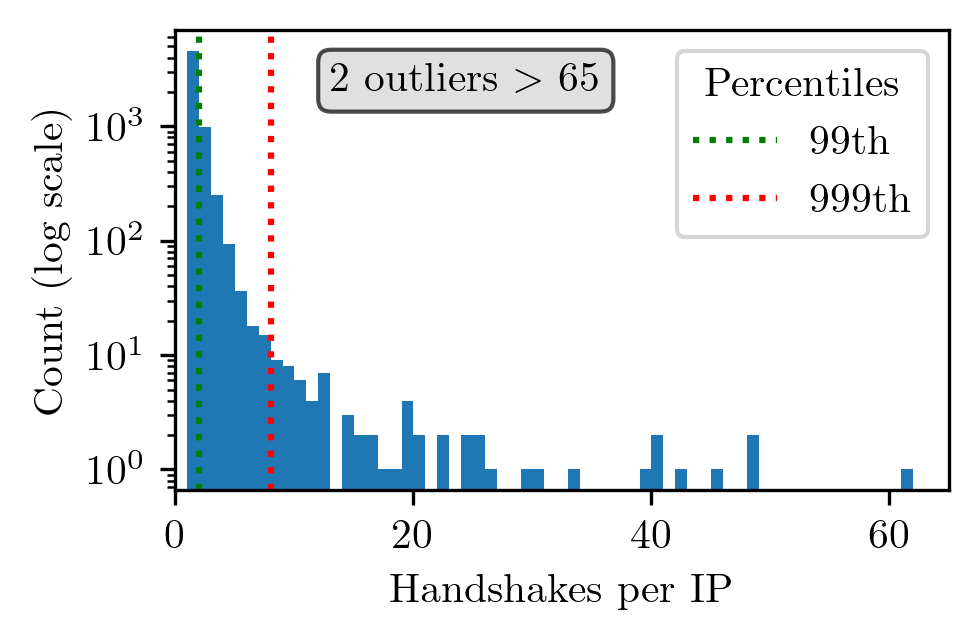

In [10]:
def analyze_handshake_flooding(peer_packets_df, result_df):
    cmd_1001_data = peer_packets_df[peer_packets_df['command'] == '1001'].copy()
    cmd_1001_data = cmd_1001_data.sort_values(['source_ip', 'timestamp'])
    
    ip_rates = {}
    window_duration = pd.Timedelta(minutes=8)
    
    for source_ip in cmd_1001_data['source_ip'].unique():
        ip_data = cmd_1001_data[cmd_1001_data['source_ip'] == source_ip]
        timestamps = ip_data['timestamp'].values
        
        if len(timestamps) < 2:
            ip_rates[source_ip] = 0
            continue
            
        window_counts = []
        i = 0
        
        while i < len(timestamps):
            window_start = timestamps[i]
            window_end = window_start + window_duration
            
            count = 0
            j = i
            while j < len(timestamps) and timestamps[j] < window_end:
                count += 1
                j += 1
            
            window_counts.append(count)
            
            # find next window
            next_window_start = window_start + window_duration
            # if there is one
            while i < len(timestamps) and timestamps[i] < next_window_start:
                i += 1
                
            # if not, break
            if i >= len(timestamps):
                break
        
        # Average rate across all windows
        avg_rate = np.mean(window_counts) if window_counts else 0
        ip_rates[source_ip] = avg_rate
    
    result_df['1001_window_rate'] = result_df['source_ip'].map(ip_rates)

    all_data = peer_packets_df.copy()
    command_counts = all_data[all_data['command'] == '1001'].groupby('source_ip').size()
    
    result_df['total_handshakes'] = result_df['source_ip'].map(command_counts)

    print('-'*50)
    print(f"Handshake flooding analysis")
    print('-'*50)
    print("Top 5 IPs with most handshakes: ")
    print(command_counts.nlargest(5))
    print("Top 5 IPs with most handshakes per 20 minutes: ")


    # Handshake Plots
    plt.figure(figsize=(3.13, 2), dpi=300)
    plt.hist(command_counts.values, bins=65, range=(0, 65), log=True)
    plt.xlim(0, 65)
    plt.axvline(np.percentile(command_counts.values, 90), color='green', linestyle=':', label='99th')
    plt.axvline(np.percentile(command_counts.values, 99), color='red', linestyle=':', label='999th')

    outlier_count = sum(x > 65 for x in command_counts.values)
    plt.text(0.55, 0.93, f'{outlier_count} outliers $>$ 65', fontsize=10,
             transform=plt.gca().transAxes, ha='right', va='top',
             bbox=dict(boxstyle='round,pad=0.3', facecolor='lightgray', alpha=0.7))
    plt.xlabel(f'Handshakes per IP')
    plt.ylabel(f'Count (log scale)')
    plt.legend(title='Percentiles', fontsize=10, title_fontsize=10)
    plt.tight_layout(pad=0.2)
    plt.show()
    
    return result_df

result_df = analyze_handshake_flooding(peer_packets_df, result_df)


In [11]:
def analyze_connections():
    all_data = peer_packets_df.copy()
    all_data = all_data.sort_values(['source_ip', 'source_port', 'timestamp'])

    all_data['source_endpoint'] = all_data['source_ip'].astype(str) + ':' + all_data['source_port'].astype(str)
    all_data['source_endpoint_cat'] = all_data['source_endpoint'].astype('category')

    # shift to later compare current vs prev IP
    all_data['prev_endpoint'] = all_data['source_endpoint_cat'].shift(1)
    all_data['time_diff'] = all_data['timestamp'].diff().dt.total_seconds()

    # mask logic to identify breaks if IP changes, time is bigger 120s (idle), first row, handshake
    all_data['is_break'] = (
        (all_data['source_endpoint_cat'] != all_data['prev_endpoint']) | 
        (all_data['time_diff'] > 120) | 
        (all_data['time_diff'].isna()) | 
        (all_data['command'] == '1001')
    )
    all_data['connection_id'] = all_data['is_break'].cumsum()

    # filter already for valid conns
    grouped = all_data.groupby('connection_id')
    connection_sizes = grouped.size()
    valid_conns = connection_sizes >= 1
    valid_conn_ids = valid_conns[valid_conns].index

    conn_info = []

    for conn_id in valid_conn_ids:
        conn = grouped.get_group(conn_id)
        source_ip = conn['source_ip'].iloc[0]
        conn_row = {
            'source_ip': source_ip,
        }

        command_counts = conn['command'].value_counts()
        conn_row.update(command_counts.to_dict())

        commands = np.array(conn['command'])
        monero_flags = np.array(conn['monero_flags'])
        timestamps = np.array(conn['timestamp'])
        
        duration = timestamps[-1] - timestamps[0]
        conn_row['duration'] = duration / np.timedelta64(1, 's')

        base_mask = (commands == '1001') | (commands == '1002') | (commands == '1003')
        

        conn_info.append(conn_row)
    
    conn_df = pd.DataFrame(conn_info)
    return conn_df

conn_df = analyze_connections()
    

In [39]:
def plot_command_timeline(base_commands, base_flags, base_series):
   # Take first 30 entries
   commands = base_commands[:30]
   flags = base_flags[:30]
   times = base_series[:30]
   
   # Convert datetime to seconds from start
   time_seconds = (times - times.iloc[0]).dt.total_seconds()
   
   # Create category values
   categories = []
   for cmd, flag in zip(commands, flags):
       if cmd == '1001':
           categories.append(1)
       elif cmd == '1002' and flag == '1':
           categories.append(2)
       elif cmd == '1002' and flag == '2':
           categories.append(3)
       elif cmd == '1003':
           categories.append(4)
   
   # Plot
   plt.figure(figsize=(10, 6))
   plt.plot(time_seconds, categories, marker='o', linewidth=2, markersize=4)
   plt.xlabel('Time (seconds)')
   plt.ylabel('Category')
   plt.yticks([1, 2, 3, 4], ['1001', '1002+1', '1002+2', '1003'])
   plt.grid(True, alpha=0.3)
   plt.title('Command Timeline')
   plt.tight_layout()
   plt.show()

/tmp/ipykernel_4546/516895540.py:33: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(category_labels if show_ylabel else ['', '', '', ''], fontsize=10)
/tmp/ipykernel_4546/516895540.py:33: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(category_labels if show_ylabel else ['', '', '', ''], fontsize=10)
/tmp/ipykernel_4546/516895540.py:33: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(category_labels if show_ylabel else ['', '', '', ''], fontsize=10)
/tmp/ipykernel_4546/516895540.py:33: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(category_labels if show_ylabel else ['', '', '', ''], f

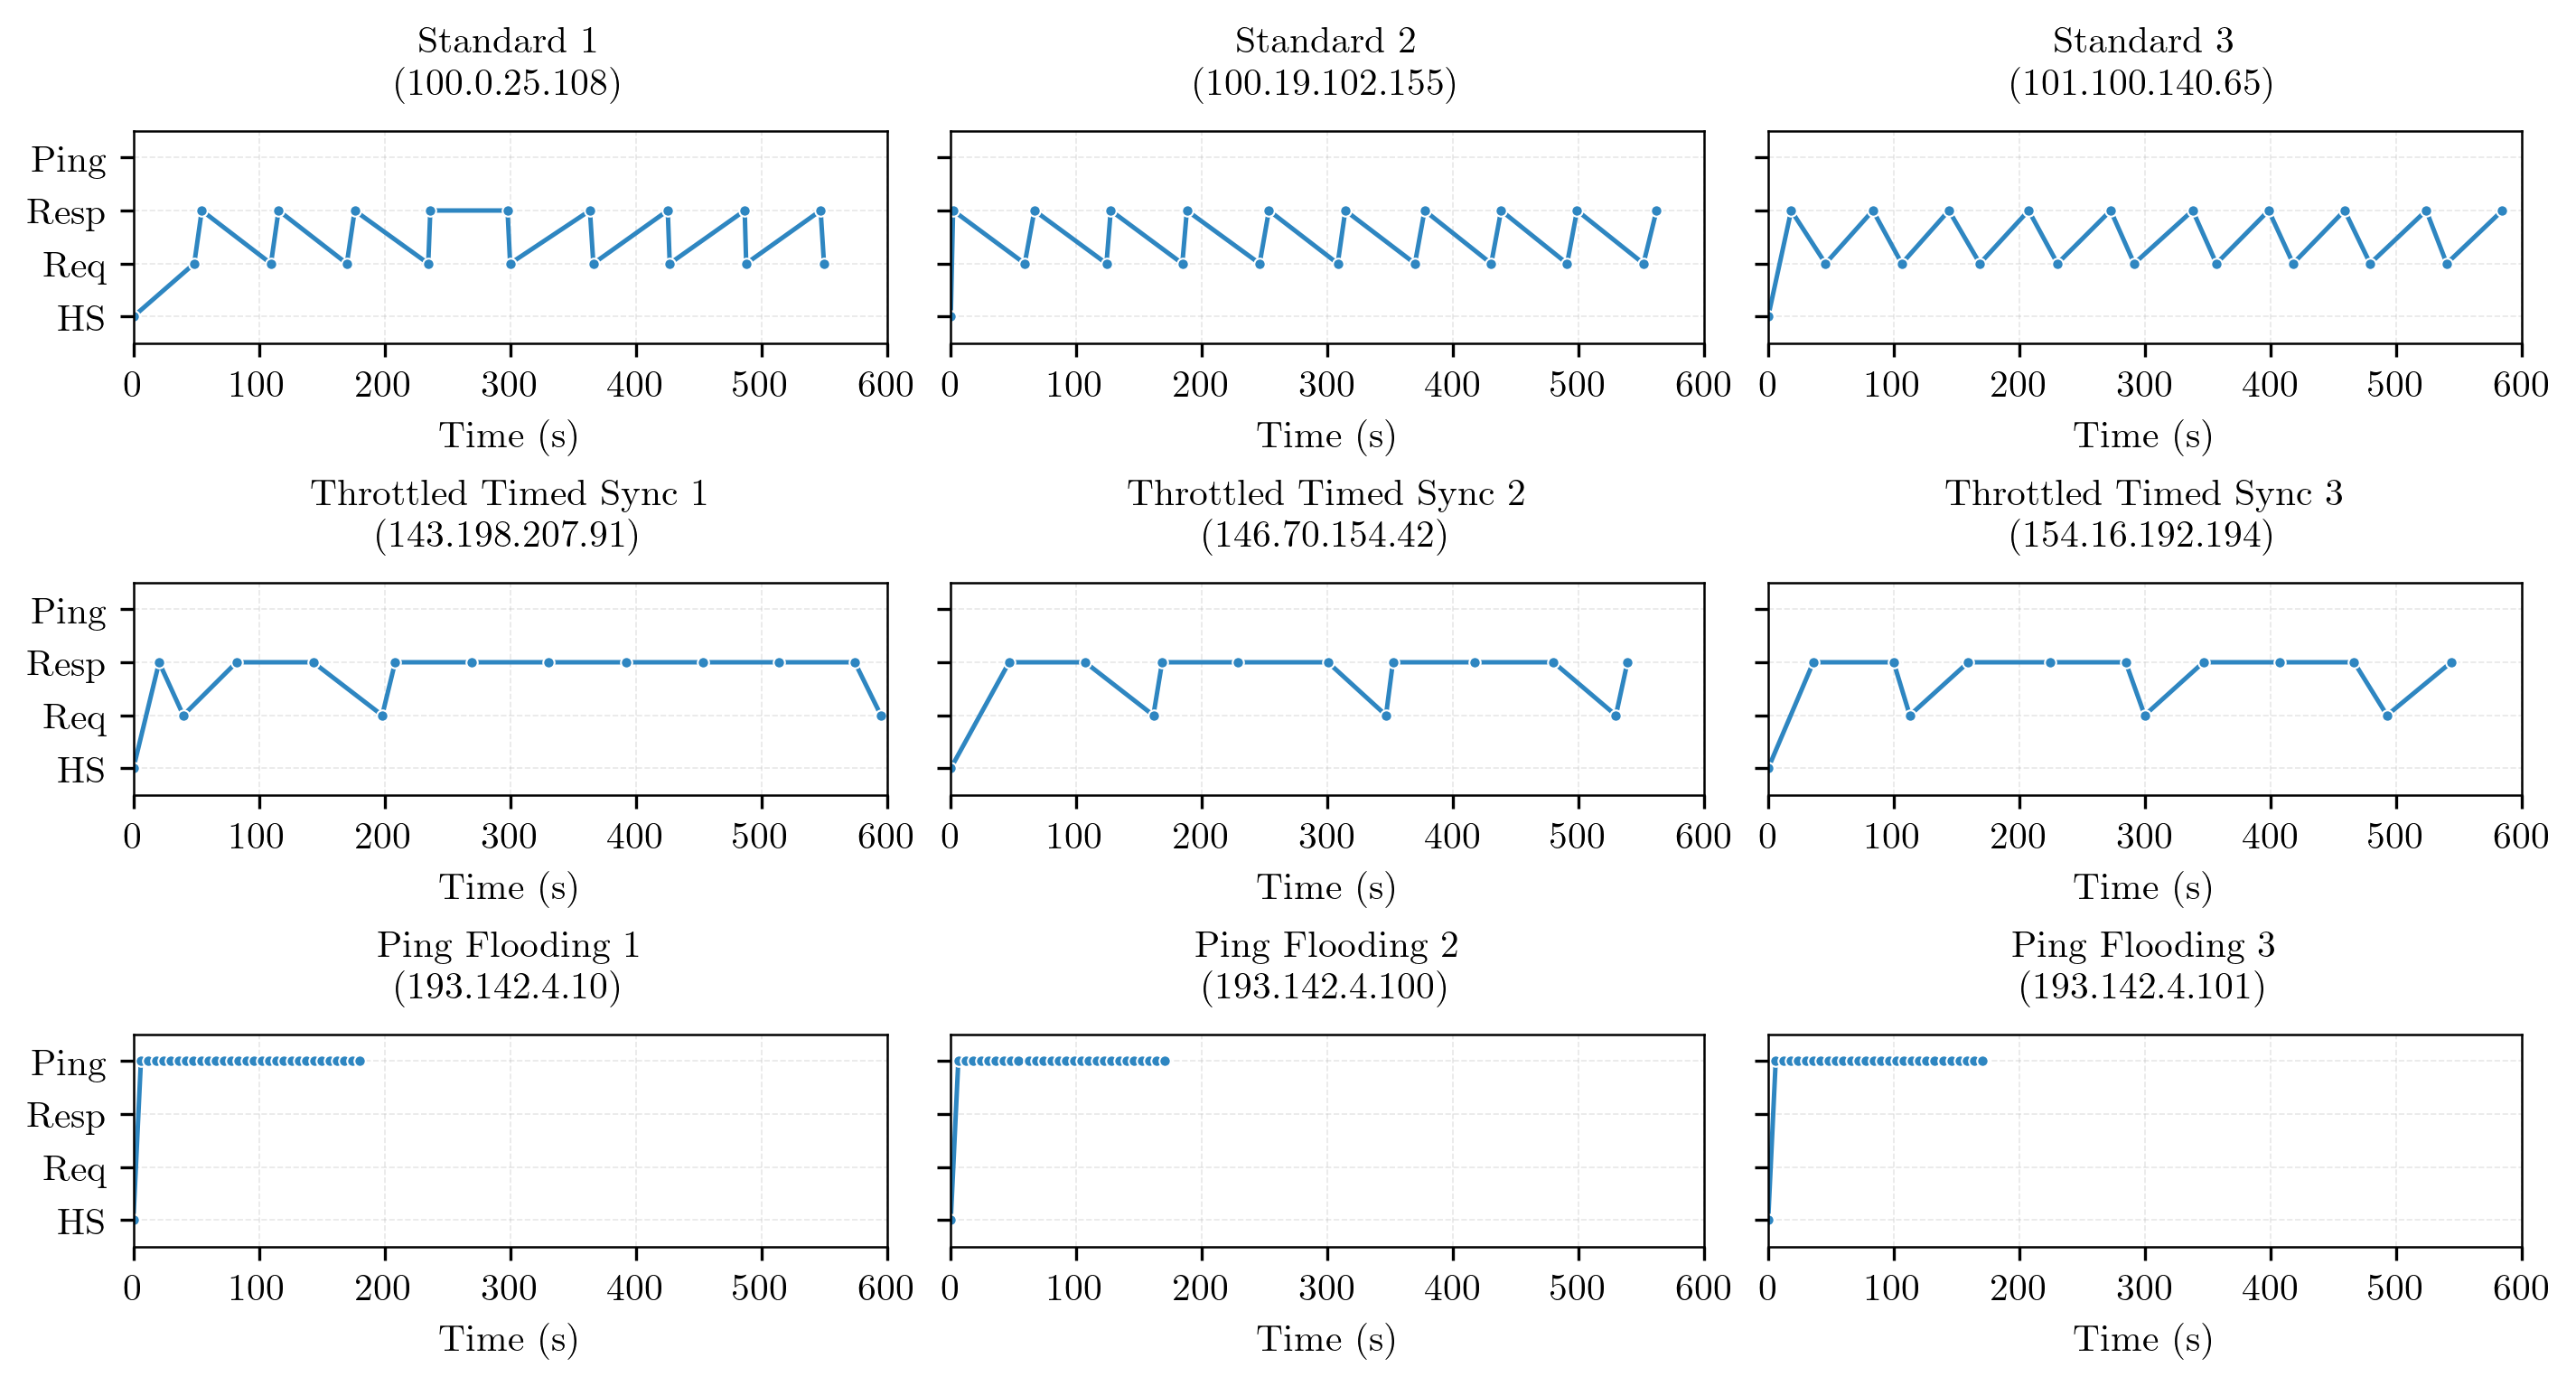

In [98]:
plt.rcParams.update({
    'font.size': 10,          # Smaller font for double column
    'font.family': 'serif',
    'axes.linewidth': 0.6,   # Thinner lines
    'grid.linewidth': 0.4,
    'lines.linewidth': 1.0,  # Thinner lines
    'lines.markersize': 2,   # Smaller markers
    'figure.dpi': 300,
    'savefig.dpi': 300,
    'savefig.bbox': 'tight'
})

def get_command_category(cmd, flag):
    """Map commands and flags to categories"""
    category_map = {
        '1001': 1,           # Handshake
        ('1002', '1'): 2,    # Timed Sync Request
        ('1002', '2'): 3,    # Timed Sync Response
        '1003': 4            # Ping
    }
    
    if cmd in ['1002']:
        return category_map.get((cmd, flag), 0)
    return category_map.get(cmd, 0)

def setup_axis_appearance(ax, time_duration_seconds, show_ylabel=True):
    """Configure axis appearance for LaTeX paper"""
    #category_labels = ['Handshake', 'TS Request', 'TS Response', 'Ping']
    category_labels = ['HS', 'Req', 'Resp', 'Ping']
    

    ax.set_xlabel('Time (s)', fontsize=10)
    ax.set_yticklabels(category_labels if show_ylabel else ['', '', '', ''], fontsize=10)
    ax.tick_params(axis='both', which='major', labelsize=10)
    ax.set_yticks([1, 2, 3, 4])
    ax.set_ylim(0.5, 4.5)
    ax.set_xlim(0, time_duration_seconds)
    ax.grid(True, alpha=0.3, linestyle='--')

def plot_command_timeline_subplot(ax, base_commands, base_flags, base_series, title, 
                                time_duration_seconds=300, show_ylabel=True):
    """Plot command timeline on given axis"""
    
    if len(base_series) == 0:
        ax.text(0.5, 0.5, 'No data', transform=ax.transAxes, 
                ha='center', va='center', fontsize=7)
        ax.set_title(title, fontsize=8, pad=8)

        setup_axis_appearance(ax, time_duration_seconds, show_ylabel)
        return
    
    # Convert to seconds from start and filter by duration
    time_seconds = (base_series - base_series.iloc[0]).dt.total_seconds()
    time_mask = time_seconds <= time_duration_seconds
    
    if not time_mask.any():
        ax.text(0.5, 0.5, 'No data in time range', transform=ax.transAxes, 
                ha='center', va='center', fontsize=9)
        ax.set_title(title, fontsize=10, pad=10)
        setup_axis_appearance(ax, time_duration_seconds, show_ylabel)
        return
    
    # Filter data and create categories
    commands_filtered = base_commands[time_mask]
    flags_filtered = base_flags[time_mask]
    time_filtered = time_seconds[time_mask]
    
    categories = [get_command_category(cmd, flag) 
                  for cmd, flag in zip(commands_filtered, flags_filtered)]
    
    # Plot with improved styling
    ax.plot(time_filtered, categories, marker='o', linewidth=1.2, markersize=3,
            color='#2E86C1', markerfacecolor='#2E86C1', markeredgecolor='white', 
            markeredgewidth=0.5)
    
    ax.set_title(title, fontsize=10, pad=10, weight='bold')
    setup_axis_appearance(ax, time_duration_seconds, show_ylabel)

def classify_connection(result_row, duration_m, commands, ts_latency_lower, ts_latency_upper, 
                       min_duration_minutes):
    """Classify connection type based on characteristics"""
    
    if commands[0] != '1001':  # Must start with handshake
        return None
        
    conditions = {
        'standard': (
            (result_row['ts_latency'] < ts_latency_lower) &
            pd.isna(result_row['ping_frequency']) & 
            result_row['has_support_flags'] & 
            (duration_m > min_duration_minutes)
        ),
        'nonstandard': (
            (result_row['ts_latency'] > ts_latency_upper) &
            result_row['has_support_flags'] & 
            (duration_m > min_duration_minutes)
        ),
        'ping': (
            (result_row['ping_frequency'] > 0) & 
            (result_row['ping_frequency'] < 10)
        )
    }
    
    for conn_type, condition in conditions.items():
        if condition:
            return conn_type
    return None

def analyze_connections(result_df, max_connections_per_type=2, min_duration_minutes=8, 
                       min_ping_commands=3, time_duration_seconds=300):
    
    df_indexed = result_df.set_index('source_ip')
    ts_latency_lower = result_df['ts_latency'].quantile(0.5)
    ts_latency_upper = result_df['ts_latency'].quantile(0.99)

    # Process connection data
    all_data = peer_packets_df.copy()
    all_data = all_data.sort_values(['source_ip', 'source_port', 'timestamp'])
    all_data['source_endpoint'] = all_data['source_ip'].astype(str) + ':' + all_data['source_port'].astype(str)
    all_data['source_endpoint_cat'] = all_data['source_endpoint'].astype('category')
    all_data['prev_endpoint'] = all_data['source_endpoint_cat'].shift(1)
    all_data['time_diff'] = all_data['timestamp'].diff().dt.total_seconds()

    # Identify connection breaks
    all_data['is_break'] = (
        (all_data['source_endpoint_cat'] != all_data['prev_endpoint']) | 
        (all_data['time_diff'] > 120) | 
        (all_data['time_diff'].isna()) | 
        (all_data['command'] == '1001')
    )
    all_data['connection_id'] = all_data['is_break'].cumsum()

    # Collect connections by type
    connection_data = {conn_type: [] for conn_type in ['standard', 'nonstandard', 'ping']}
    type_counts = {conn_type: 0 for conn_type in connection_data.keys()}

    grouped = all_data.groupby('connection_id')
    valid_conn_ids = grouped.size()[grouped.size() >= 1].index

    for conn_id in valid_conn_ids:
        conn = grouped.get_group(conn_id)
        source_ip = conn['source_ip'].iloc[0]
        
        try:
            result_row = df_indexed.loc[f'{source_ip}']
        except KeyError:
            continue

        commands = np.array(conn['command'])
        timestamps = np.array(conn['timestamp'])
        duration_m = (timestamps[-1] - timestamps[0]) / 1_000_000_000 / 60 if len(commands) > 1 else 0
        
        # Classify connection
        conn_type = classify_connection(result_row, duration_m, commands, 
                                      ts_latency_lower, ts_latency_upper, min_duration_minutes)
        
        if (conn_type and type_counts[conn_type] < max_connections_per_type and
            (conn_type != 'ping' or len(commands[commands == '1003']) >= min_ping_commands)):
            
            # Prepare base data for plotting
            base_mask = np.isin(commands, ['1001', '1002', '1003'])
            base_series = pd.Series(timestamps[base_mask])
            
            connection_data[conn_type].append({
                'commands': commands[base_mask],
                'flags': np.array(conn['monero_flags'])[base_mask],
                'series': base_series,
                'source_ip': source_ip
            })
            type_counts[conn_type] += 1

    fig, axes = plt.subplots(3, max_connections_per_type, 
                    figsize=(3.13*max_connections_per_type, 5),  # Fixed width for half page
                    constrained_layout=True)
    
    if max_connections_per_type == 1:
        axes = axes.reshape(-1, 1)
    
    connection_types = ['standard', 'nonstandard', 'ping']
    titles = ['Standard', 'Throttled Timed Sync', 'Ping Flooding']
    
    for i, conn_type in enumerate(connection_types):
        for j in range(max_connections_per_type):
            if j < len(connection_data[conn_type]):
                data = connection_data[conn_type][j]
                title = f"{titles[i]} {j+1}\n({data['source_ip']})"
                plot_command_timeline_subplot(
                    axes[i, j], data['commands'], data['flags'], 
                    data['series'], title, time_duration_seconds, show_ylabel=(j==0)
                )
            else:
                axes[i, j].text(0.5, 0.5, f'No {conn_type}\nconnection {j+1}', 
                               transform=axes[i, j].transAxes, ha='center', va='center',
                               fontsize=9)
                axes[i, j].set_title(f"{conn_type.title()} {j+1}", fontsize=10, pad=10)
                setup_axis_appearance(axes[i, j], time_duration_seconds, show_ylabel=(j==0))
    
    #fig.suptitle(f'Network Connection Analysis (First {time_duration_seconds}s)', 
    #            fontsize=12, weight='bold', y=0.98)
    
    return fig

fig = analyze_connections(result_df, 
                         max_connections_per_type=3, 
                         min_duration_minutes=8,
                         min_ping_commands=3, 
                         time_duration_seconds=600) 

# Save for LaTeX
fig.savefig('results/graphs/connection_vis.pdf', format='pdf', bbox_inches='tight', pad_inches=0.1)
plt.show()

# Peer Lists per Peer
- all peer lists of a peer aggregated

In [79]:
unique_peers_by_source = peers_df.groupby('source_ip')['ip'].apply(lambda x: x.unique().tolist()).reset_index()
unique_peers_by_source.columns = ['source_ip', 'unique_peer_ips']
#print(unique_peers_by_source.head())

unique_peers_by_source['peer_count'] = unique_peers_by_source['unique_peer_ips'].apply(len)
unique_peers_by_source = unique_peers_by_source[unique_peers_by_source['peer_count'] > 250]

# Analyze sizes
peer_counts = unique_peers_by_source.set_index('source_ip')['peer_count']

# Convert to dict for easier access
peer_sets = {row['source_ip']: set(row['unique_peer_ips']) 
            for _, row in unique_peers_by_source.iterrows()}

# Calculate pairwise overlaps
overlaps = []
for source1, source2 in combinations(peer_sets.keys(), 2):
   intersection = len(peer_sets[source1] & peer_sets[source2])
   union = len(peer_sets[source1] | peer_sets[source2])
   jaccard = intersection / union if union > 0 else 0
   
   overlaps.append({
       'source1': source1, 'source2': source2,
       'intersection': intersection, 'jaccard_similarity': jaccard,
       'union': union
   })

overlap_df = pd.DataFrame(overlaps)

max_sim_by_ip = overlap_df.groupby('source1')['jaccard_similarity'].max()
result_df['max_pl_sim'] = result_df['source_ip'].map(max_sim_by_ip)

print(f"\nHighest overlaps:")
print(overlap_df.nlargest(5, 'intersection')[['source1', 'source2', 'intersection', 'union', 'jaccard_similarity']])
#print(f"\nSmallest overlaps:")
#print(overlap_df.nsmallest(5, 'intersection')[['source1', 'source2', 'intersection', 'jaccard_similarity']])
quantiles = [0.5, 0.7, 0.8, 0.9, 0.95, 0.99, 0.999, 0.9999]
for quantile in quantiles:
    print(f"{quantile}th percentile: {overlap_df['jaccard_similarity'].quantile(quantile)}")
print(f"\nHighest overlaps:")
print(overlap_df.nlargest(15, 'intersection')[['source1', 'source2', 'intersection', 'jaccard_similarity']])


Highest overlaps:
                source1       source2  intersection  union  jaccard_similarity
2240390    34.146.205.9  5.78.129.182          2982   4840            0.616116
2240157    34.146.205.9   34.85.1.254          2972   4751            0.625553
2239055  34.124.182.107  34.146.205.9          2969   4790            0.619833
2239310  34.124.182.107  5.78.129.182          2968   4839            0.613350
2473184    5.223.57.127  5.78.129.182          2960   4828            0.613090
0.5th percentile: 0.10434173669467788
0.7th percentile: 0.1203288490284006
0.8th percentile: 0.1300114547537228
0.9th percentile: 0.14539682539682539
0.95th percentile: 0.16017868538608807
0.99th percentile: 0.19524940617577197
0.999th percentile: 0.2648649538999987
0.9999th percentile: 0.3837567343500222

Highest overlaps:
                source1        source2  intersection  jaccard_similarity
2240390    34.146.205.9   5.78.129.182          2982            0.616116
2240157    34.146.205.9    34.85.1.

In [80]:
SIMILARITY_THRESHOLD = result_df['max_pl_sim'].quantile(0.95)
high_sim_pairs = overlap_df[overlap_df['jaccard_similarity'] >= SIMILARITY_THRESHOLD].copy()
#print(high_sim_pairs.head())

groups = []

for _, row in high_sim_pairs.iterrows():
    source1, source2 = row['source1'], row['source2']
    sim = row['jaccard_similarity']

    found_group = None
    for group in groups:
        if source1 in group['sources'] or source2 in group['sources']:
            found_group = group
            break
    
    if not found_group is None:
        found_group['sources'].add(source1)
        found_group['sources'].add(source2)
        found_group['similarities'].append(sim)
    else:
        groups.append({
            'sources': {source1, source2},
            'similarities': [sim]
        })
    
final_groups = []

for group in groups:
    if len(group['sources']) > 1:
        sources_list = list(group['sources'])
        similarities = group['similarities']
        final_groups.append({
            'sources': sources_list,
            'avg_similarity': sum(similarities) / len(similarities),
            'min_similarity': min(similarities),
            'max_similarity': max(similarities),
            'num_pairs': len(similarities)
        })

print(f"\nFound {len(final_groups)} similarity groups.\nMost similar groups: ")
source_to_group = {}
for i, group in enumerate(final_groups, 1):
    for source_ip in group['sources']:
        source_to_group[source_ip] = len(group['sources'])
    if len(group['sources']) > 2: #group['avg_similarity'] > 0.65:
        print(f"Group {i} ({len(group['sources'])} sources):")
        print(f"  Sources: {group['sources']}")
        print(f"  Avg similarity: {group['avg_similarity']:.3f}")
        print(f"  Range: {group['min_similarity']:.3f} - {group['max_similarity']:.3f}")
        print(f"  Based on {group['num_pairs']} pairs")

result_df[f'sim_group_{node}'] = result_df['source_ip'].map(source_to_group)

if final_groups:
    group_sizes = [len(group['sources']) for group in final_groups]
    avg_similarities = [group['avg_similarity'] for group in final_groups]
    print(f"\nOverall stats:")
    print(f"Total sources in groups: {sum(group_sizes)}")
    print(f"Average group size: {sum(group_sizes)/len(group_sizes):.1f}")
    print(f"Largest group: {max(group_sizes)} sources")
    print(f"Average of group similarities: {sum(avg_similarities)/len(avg_similarities):.3f}")


Found 28 similarity groups.
Most similar groups: 
Group 1 (137 sources):
  Sources: ['3.112.138.57', '209.38.167.250', '108.180.46.52', '82.19.24.159', '5.104.84.64', '45.84.107.128', '217.24.207.122', '46.4.28.18', '172.56.67.6', '45.84.107.198', '203.123.97.227', '147.135.131.11', '71.227.185.229', '95.181.173.108', '88.80.26.4', '116.203.254.206', '162.216.231.132', '34.162.141.93', '104.155.200.188', '162.55.88.217', '92.40.190.200', '192.184.212.128', '45.84.107.76', '134.199.179.79', '195.47.238.91', '35.201.2.32', '45.84.107.55', '5.223.57.127', '185.220.101.54', '136.49.20.217', '153.242.149.6', '45.84.107.222', '192.42.116.179', '210.1.203.192', '45.84.107.74', '159.203.65.163', '23.113.152.136', '124.189.33.241', '185.6.13.181', '192.223.30.30', '82.66.181.243', '195.26.86.73', '51.178.97.131', '192.99.16.172', '5.161.47.56', '91.219.236.91', '185.240.242.141', '5.78.119.189', '94.72.105.104', '190.115.19.98', '135.181.147.50', '34.162.180.245', '185.107.57.65', '5.255.102.9

# Peer Lists Individually

In [81]:
pl_by_source = peers_df.groupby('pl_identifier').agg({
    'ip': lambda x: x.tolist(),
    'source_ip': 'first',
    }).reset_index()
pl_by_source.columns = ['source_pl', 'peer_ips', 'source_ip']
#print(unique_peers_by_source.head())

pl_by_source['peer_count'] = pl_by_source['peer_ips'].apply(len)
pl_by_source = pl_by_source[pl_by_source['peer_count'] > 249]

peer_counts = pl_by_source.set_index('source_pl')['peer_count']

pl_counters = {row['source_pl']: Counter(row['peer_ips'])
               for _, row in pl_by_source.iterrows()}

source_ip_lookup = pl_by_source.set_index('source_pl')['source_ip'].to_dict()

overlaps = []
for source1, source2 in combinations(pl_counters.keys(), 2):
    counter1, counter2 = pl_counters[source1], pl_counters[source2]
    
    # Common IPs (intersection)
    common_ips = counter1 & counter2
    intersection_count = sum(common_ips.values())
    
    # Union with frequencies
    union_counter = counter1 | counter2
    union_count = sum(union_counter.values())
    
    jaccard = intersection_count / union_count if union_count > 0 else 0
   
    overlaps.append({
        'source1': source1, 
        'source2': source2,
        'source1_ip': source_ip_lookup[source1],
        'source2_ip': source_ip_lookup[source2],
        'intersection': intersection_count, 
        'jaccard_similarity': jaccard,
        'union': union_count
    })

overlap_df = pd.DataFrame(overlaps)
overlap_df.to_csv(f'results/node_results/{node}_pl_df.csv', index=False)

0.5th percentile: 0.030927835051546393
0.7th percentile: 0.03734439834024896
0.8th percentile: 0.041666666666666664
0.9th percentile: 0.05263157894736842
0.95th percentile: 0.1185682326621924
0.99th percentile: 0.16009280742459397
0.999th percentile: 0.1792452830188679
0.9999th percentile: 0.19617224880382775


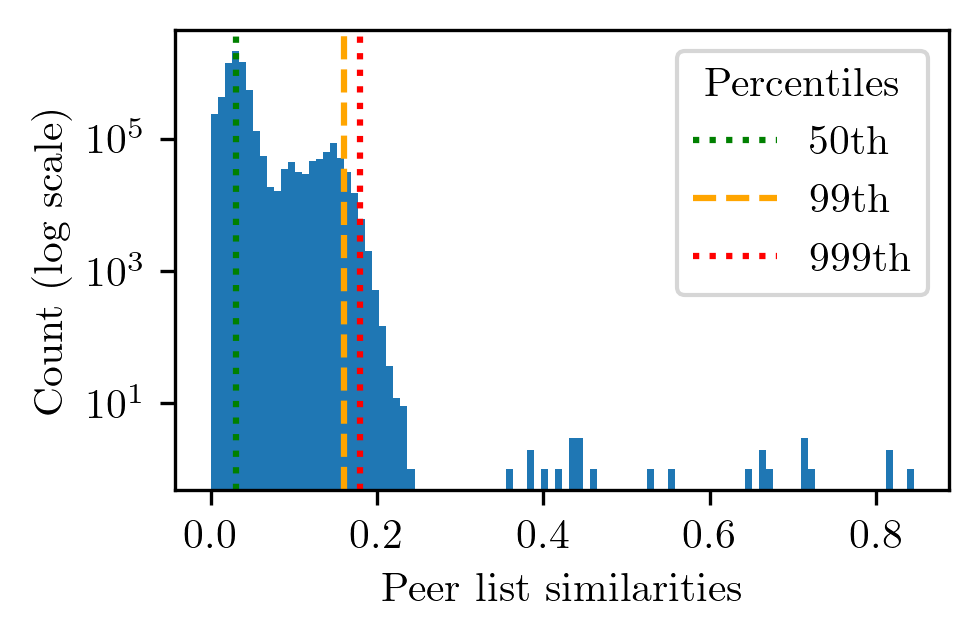

source1_ip
138.199.6.205      41789
46.19.136.246      12501
162.218.65.219       146
194.164.32.12        103
185.193.226.35        76
74.75.42.138          69
73.63.192.88          67
173.47.215.77         55
102.219.9.57          51
35.151.225.151        38
5.104.84.64           36
91.198.115.199        33
209.222.252.221       33
162.218.65.178        32
72.95.224.170         30
209.222.252.119       28
91.198.115.187        28
162.218.65.86         27
91.198.115.23         26
162.218.65.135        26
Name: count, dtype: int64


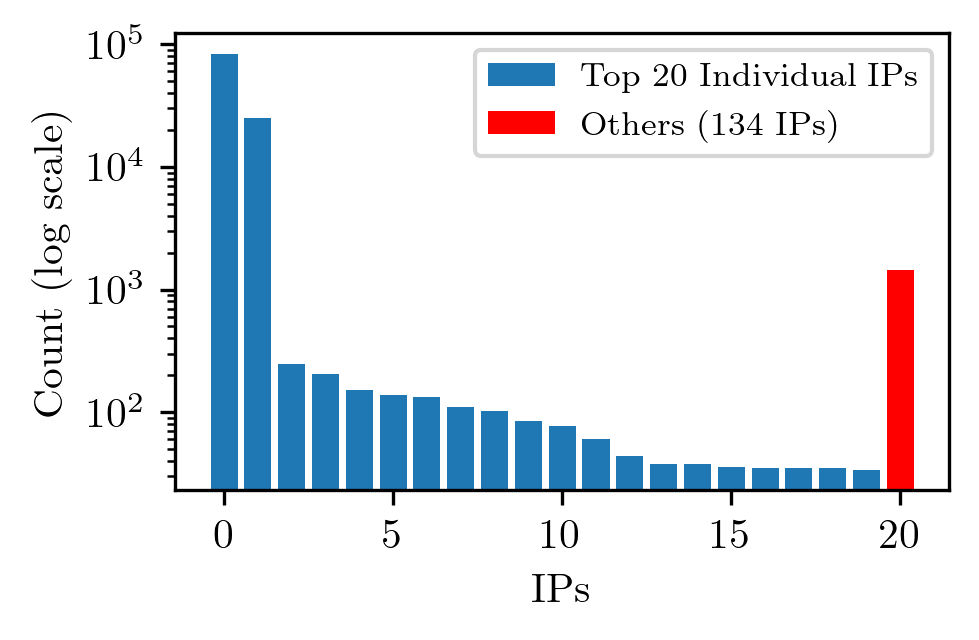

In [82]:
quantiles = [0.5, 0.7, 0.8, 0.9, 0.95, 0.99, 0.999, 0.9999]
for quantile in quantiles:
    print(f"{quantile}th percentile: {overlap_df['jaccard_similarity'].quantile(quantile)}")
#print(f"\nHighest overlaps:")
#print(overlap_df.nlargest(15, 'jaccard_similarity')[['source1', 'source2', 'intersection', 'union', 'jaccard_similarity']])

plt.figure(figsize=(3.13, 2), dpi=300)
plt.hist(overlap_df['jaccard_similarity'], bins=100, log=True)
plt.axvline(overlap_df['jaccard_similarity'].quantile(0.50), color='green', linestyle=':', label='50th')
plt.axvline(overlap_df['jaccard_similarity'].quantile(0.99), color='orange', linestyle='--', label='99th')
plt.axvline(overlap_df['jaccard_similarity'].quantile(0.999), color='red', linestyle=':', label='999th')
plt.xlabel(f'Peer list similarities')
plt.ylabel(f'Count (log scale)')
plt.legend(title='Percentiles', fontsize=10, title_fontsize=10)
plt.tight_layout(pad=0.2)
plt.show()

high_sim_df = overlap_df[overlap_df['jaccard_similarity']>overlap_df['jaccard_similarity'].quantile(0.99)]
#print(high_sim_df.head(1))
#print(len(high_sim_df))
print(high_sim_df['source1_ip'].value_counts().head(20))

all_ips = pd.concat([
    high_sim_df['source1_ip'], 
    high_sim_df['source2_ip']
])

# Get value counts for all IPs
combined_ip_counts = all_ips.value_counts()

# Plot combined results
top_ips = combined_ip_counts.head(20)
others_count = combined_ip_counts.iloc[20:].sum()

plt.figure(figsize=(3.13, 2), dpi=300)
plt.bar(range(len(top_ips)), top_ips.values, label='Top 20 Individual IPs')
plt.bar(len(top_ips), others_count, color='red', 
        label=f'Others ({len(combined_ip_counts) - 20} IPs)')
plt.yscale('log')
plt.xlabel('IPs')
plt.ylabel('Count (log scale)')
#plt.title('IP Frequency')
plt.legend(fontsize=8)
plt.tight_layout(pad=0.2)
plt.show()

In [83]:
pl_by_source = peers_df.groupby('pl_identifier').agg({
    'ip': lambda x: x.tolist(),
    'source_ip': 'first',
    }).reset_index()
pl_by_source.columns = ['source_pl', 'peer_ips', 'source_ip']
#print(unique_peers_by_source.head())

pl_by_source['peer_count'] = pl_by_source['peer_ips'].apply(len)
pl_by_source = pl_by_source[pl_by_source['peer_count'] > 249]

peer_counts = pl_by_source.set_index('source_pl')['peer_count']

pl_counters = {row['source_pl']: Counter(row['peer_ips'])
               for _, row in pl_by_source.iterrows()}

source_ip_lookup = pl_by_source.set_index('source_pl')['source_ip'].to_dict()

overlaps = []
for source1, source2 in combinations(pl_counters.keys(), 2):
    counter1, counter2 = pl_counters[source1], pl_counters[source2]
    source1_ip = source_ip_lookup[source1]
    source2_ip = source_ip_lookup[source2]
    if source1_ip == source2_ip:
        continue
    
    # Common IPs (intersection)
    common_ips = counter1 & counter2
    intersection_count = sum(common_ips.values())
    
    # Union with frequencies
    union_counter = counter1 | counter2
    union_count = sum(union_counter.values())
    
    jaccard = intersection_count / union_count if union_count > 0 else 0
   
    overlaps.append({
        'source1': source1, 
        'source2': source2,
        'source1_ip': source1_ip,
        'source2_ip': source2_ip,
        'intersection': intersection_count, 
        'jaccard_similarity': jaccard,
        'union': union_count
    })

overlap_df = pd.DataFrame(overlaps)

0.5th percentile: 0.030927835051546393
0.7th percentile: 0.035196687370600416
0.8th percentile: 0.0395010395010395
0.9th percentile: 0.04384133611691023
0.95th percentile: 0.05042016806722689
0.99th percentile: 0.06837606837606838
0.999th percentile: 0.1210762331838565
0.9999th percentile: 0.1655011655011655


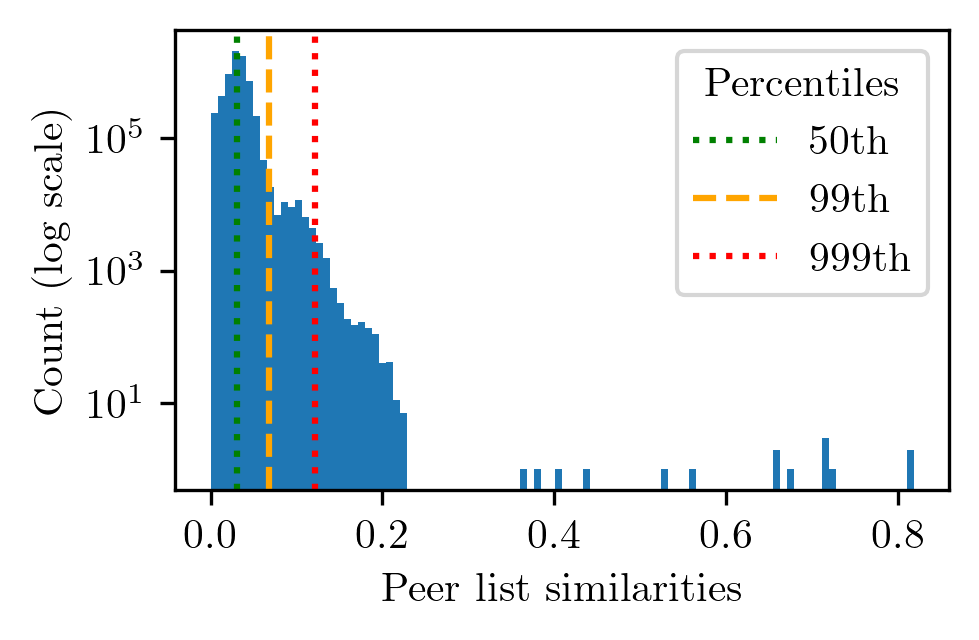

source1_ip
195.201.122.209    24387
5.104.84.64        21180
46.19.136.246       2675
138.199.6.205       2592
162.218.65.219       715
199.116.84.30        258
199.116.84.31        235
100.42.27.189        227
91.198.115.209       225
100.42.27.113        216
91.198.115.88        215
100.42.27.231        211
193.142.4.207        206
100.42.27.54         198
100.42.27.151        190
199.116.84.150       186
209.222.252.61       172
193.142.4.2          171
100.42.27.147        166
209.222.252.63       161
Name: count, dtype: int64


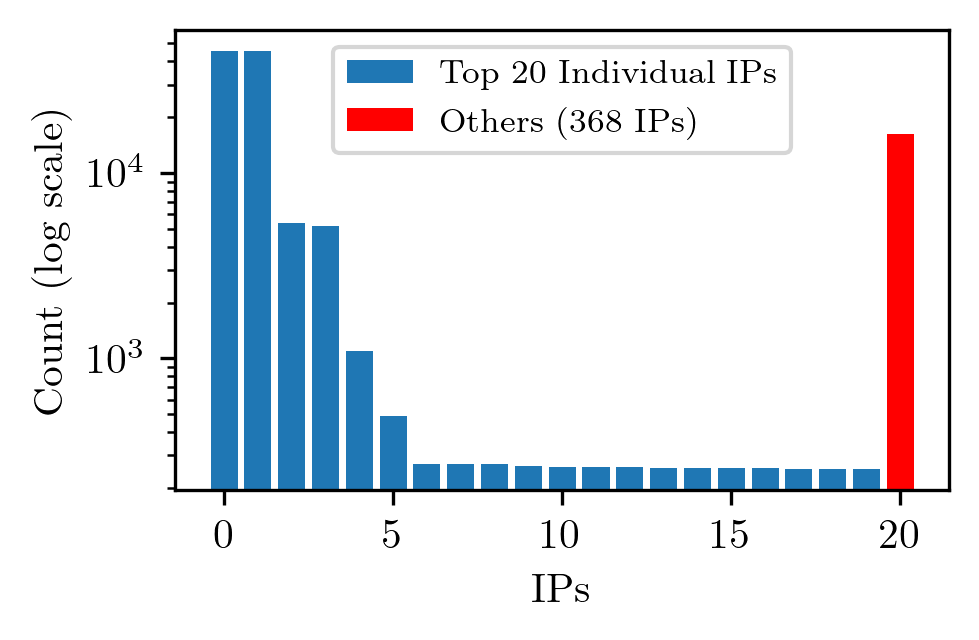

In [84]:
quantiles = [0.5, 0.7, 0.8, 0.9, 0.95, 0.99, 0.999, 0.9999]
for quantile in quantiles:
    print(f"{quantile}th percentile: {overlap_df['jaccard_similarity'].quantile(quantile)}")
#print(f"\nHighest overlaps:")
#print(overlap_df.nlargest(15, 'jaccard_similarity')[['source1', 'source2', 'intersection', 'union', 'jaccard_similarity']])

plt.figure(figsize=(3.13, 2), dpi=300)
plt.hist(overlap_df['jaccard_similarity'], bins=100, log=True)
plt.axvline(overlap_df['jaccard_similarity'].quantile(0.50), color='green', linestyle=':', label='50th')
plt.axvline(overlap_df['jaccard_similarity'].quantile(0.99), color='orange', linestyle='--', label='99th')
plt.axvline(overlap_df['jaccard_similarity'].quantile(0.999), color='red', linestyle=':', label='999th')
plt.xlabel(f'Peer list similarities')
plt.ylabel(f'Count (log scale)')
plt.legend(title='Percentiles', fontsize=10, title_fontsize=10)
plt.tight_layout(pad=0.2)
plt.show()

high_sim_df = overlap_df[overlap_df['jaccard_similarity']>overlap_df['jaccard_similarity'].quantile(0.99)]
#print(high_sim_df.head(1))
#print(len(high_sim_df))
print(high_sim_df['source1_ip'].value_counts().head(20))

all_ips = pd.concat([
    high_sim_df['source1_ip'], 
    high_sim_df['source2_ip']
])

# Get value counts for all IPs
combined_ip_counts = all_ips.value_counts()

# Plot combined results
top_ips = combined_ip_counts.head(20)
others_count = combined_ip_counts.iloc[20:].sum()

plt.figure(figsize=(3.13, 2), dpi=300)
plt.bar(range(len(top_ips)), top_ips.values, label='Top 20 Individual IPs')
plt.bar(len(top_ips), others_count, color='red', 
        label=f'Others ({len(combined_ip_counts) - 20} IPs)')
plt.yscale('log')
plt.xlabel('IPs')
plt.ylabel('Count (log scale)')
#plt.title('IP Frequency')
plt.legend(fontsize=8)
plt.tight_layout(pad=0.2)
plt.show()

In [85]:
print(pl_by_source.head())
for _, row in pl_by_source.iterrows(): 
    if row['source_ip'] == '138.199.6.205': 
        print(row)
        break

                                      source_pl  \
77     2025-06-02 08:47:53.737658_138.199.6.205   
78     2025-06-02 08:47:53.740461_46.19.136.246   
82       2025-06-02 08:47:53.870085_5.104.84.64   
86   2025-06-02 08:47:54.188303_195.201.122.209   
158      2025-06-02 08:48:54.197841_5.104.84.64   

                                              peer_ips        source_ip  \
77   [87.197.112.80, 91.107.224.99, 69.176.188.251,...    138.199.6.205   
78   [86.48.0.131, 193.142.4.243, 207.172.103.147, ...    46.19.136.246   
82   [88.97.18.142, 209.126.83.236, 217.182.142.249...      5.104.84.64   
86   [81.0.51.140, 138.197.240.34, 185.100.87.133, ...  195.201.122.209   
158  [139.84.226.244, 217.155.148.109, 159.65.96.85...      5.104.84.64   

     peer_count  
77          250  
78          250  
82          250  
86          250  
158         250  
source_pl              2025-06-02 08:47:53.737658_138.199.6.205
peer_ips      [87.197.112.80, 91.107.224.99, 69.176.188.251,...
source

In [86]:
# DIVERSITY
def calc_diversity(ip_list):
    subnets = set()
    valid_count = 0
    
    for ip in ip_list:
        try:
            subnet = str(ipaddress.IPv4Network(f"{ip}/24", strict=False).network_address) + "/24"
            subnets.add(subnet)
            valid_count += 1
        except:
            continue
    
    return len(subnets) / valid_count if valid_count > 0 else 0

pl_by_source['pl_diversity'] = pl_by_source['peer_ips'].apply(calc_diversity)

mean_pl_div = pl_by_source.groupby('source_ip')['pl_diversity'].mean()
result_df['avg_pl_diversity'] = result_df['source_ip'].map(mean_pl_div)



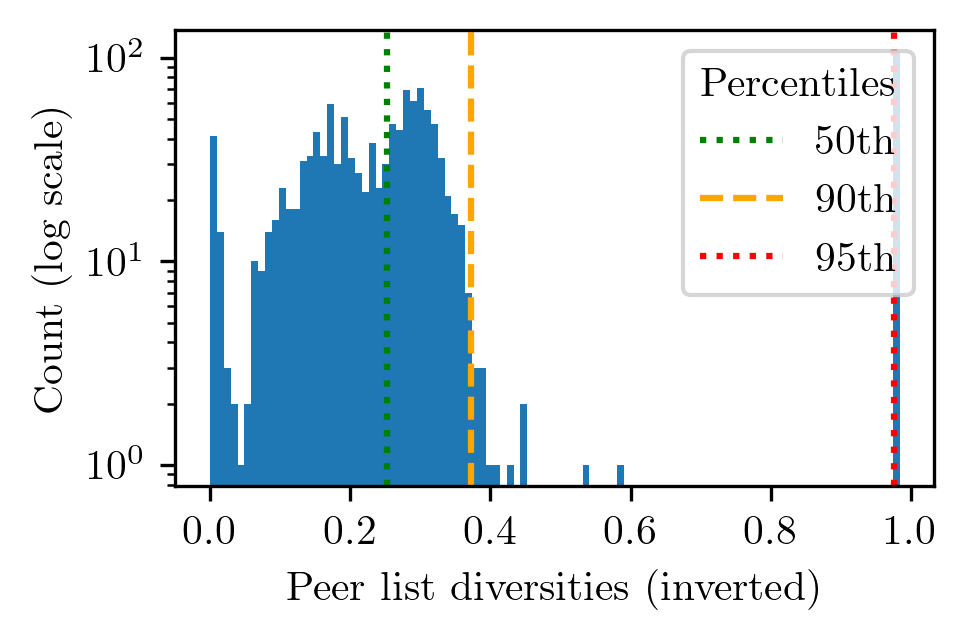

In [87]:
plt.figure(figsize=(3.13, 2), dpi=300)
inverted_data = 1 - result_df['avg_pl_diversity']
plt.hist(inverted_data, bins=100, log=True)
plt.axvline(inverted_data.quantile(0.50), color='green', linestyle=':', label='50th')
plt.axvline(inverted_data.quantile(0.90), color='orange', linestyle='--', label='90th')
plt.axvline(inverted_data.quantile(0.95), color='red', linestyle=':', label='95th')
plt.xlabel(f'Peer list diversities (inverted)')
plt.ylabel(f'Count (log scale)')
plt.legend(title='Percentiles', fontsize=10, title_fontsize=10)
plt.tight_layout(pad=0.2)
plt.show()
#plt.savefig("results/graphs/pl_sims.pdf")

In [88]:
for _, row in pl_by_source.iterrows():
    if row['pl_diversity'] < 0.5:
        print(row)
        break

source_pl                2025-06-02 08:49:54.874924_146.70.119.59
peer_ips        [100.42.27.19, 100.42.27.77, 100.42.27.146, 10...
source_ip                                           146.70.119.59
peer_count                                                    250
pl_diversity                                                0.336
Name: 244, dtype: object


SOURCE IP ANALYSIS:

Max avg_ip_frequency: 170.63
Quantiles for avg_ip_frequency: 
   0.5: 1.02
   0.7: 1.03
   0.8: 1.05
   0.9: 1.21
   0.95: 1.76
   0.99: 3.420799999999981

Max max_ip_frequency: 1441
Quantiles for max_ip_frequency: 
   0.5: 2.0
   0.7: 3.0
   0.8: 4.0
   0.9: 4.0
   0.95: 6.0
   0.99: 11.009999999999764


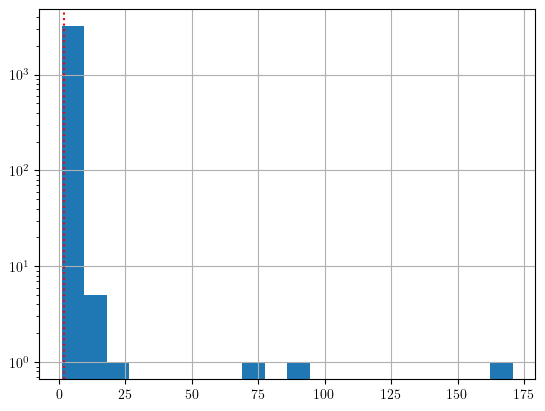

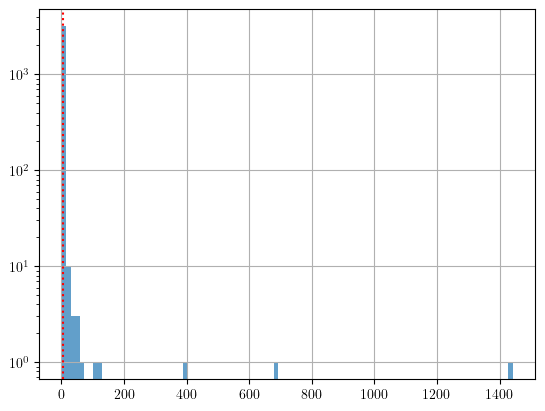

TARGET IP ANALYSIS:

Max avg_frequency_per_source: 62.5
Quantiles for avg_frequency_per_source: 
   0.5: 1.2
   0.7: 1.4
   0.8: 1.56
   0.9: 2.0
   0.95: 2.25
   0.99: 5.83

Max max_frequency_in_source: 1441
Quantiles for max_frequency_in_source: 
   0.5: 3.0
   0.7: 14.0
   0.8: 71.0
   0.9: 111.0
   0.95: 174.0
   0.99: 189.0


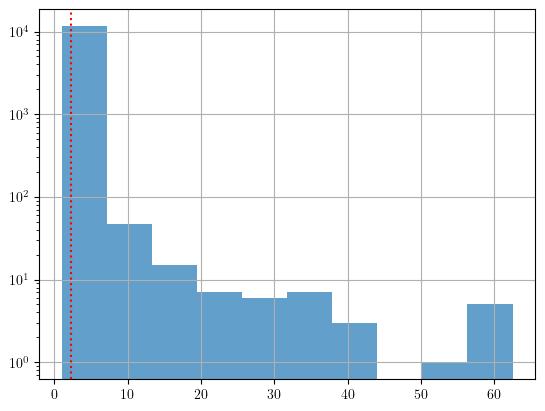

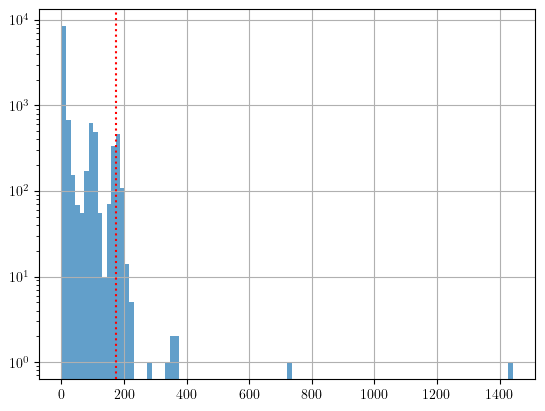

DISTRIBUTION STATISTICS:
total_unique_target_ips: 11700.00
total_unique_source_ips: 3200.00
avg_connections_per_source: 942.39
avg_unique_ips_per_source: 669.01


In [89]:
all_ips_by_source = peers_df.groupby('source_ip')['ip'].apply(lambda x: x.tolist()).reset_index()
#print(all_ips_by_source.head(5))
rows = [] 
for _, row in all_ips_by_source.iterrows():
    source_ip = row['source_ip']
    ip_list = row['ip']
    
    # Count occurrences of each IP for this source
    ip_counts = Counter(ip_list)
    
    # Create rows for each unique IP
    for ip, count in ip_counts.items():
        rows.append({
            'source_ip': source_ip,
            'target_ip': ip,
            'count': count,
            'total_ips_in_source': len(ip_list),
            'unique_ips_in_source': len(ip_counts)
        })

ip_analysis_df = pd.DataFrame(rows)

source_summary = ip_analysis_df.groupby('source_ip').agg({
    'target_ip': 'nunique',  # unique IPs per source
    'count': ['sum', 'mean', 'max', 'std'],  # count statistics
    'total_ips_in_source': 'first'
}).round(2)

source_summary.columns = ['unique_target_ips', 'total_connections', 
                         'avg_ip_frequency', 'max_ip_frequency', 
                         'std_ip_frequency', 'total_ips_in_list']

print("SOURCE IP ANALYSIS:")
columns = ['avg_ip_frequency', 'max_ip_frequency']
quantiles = [0.5, 0.7, 0.8, 0.9, 0.95, 0.99]
for c in columns: 
    print(f"\nMax {c}: {source_summary[c].max()}")
    print(f"Quantiles for {c}: ")
    for q in quantiles:
        print((f"   {q}: {source_summary[c].quantile(q)}"))
#print(source_summary.head())

source_summary['avg_ip_frequency'].hist(bins=20, log=True)
plt.axvline(source_summary["avg_ip_frequency"].quantile(0.95), color='red', linestyle=':', label='95th')
plt.show()

source_summary['max_ip_frequency'].hist(bins=100, alpha=0.7, log=True)
plt.axvline(source_summary["max_ip_frequency"].quantile(0.95), color='red', linestyle=':', label='95th')
plt.show()

target_summary = ip_analysis_df.groupby('target_ip').agg({
    'source_ip': 'nunique',  # in how many sources this IP appears
    'count': ['sum', 'mean', 'max'],  # frequency statistics
}).round(2)

target_summary.columns = ['appears_in_n_sources', 'total_occurrences', 
                         'avg_frequency_per_source', 'max_frequency_in_source']

print("TARGET IP ANALYSIS:")

columns = ["avg_frequency_per_source", "max_frequency_in_source"]
for c in columns: 
    print(f"\nMax {c}: {target_summary[c].max()}")
    print(f"Quantiles for {c}: ")
    for q in quantiles:
        print((f"   {q}: {target_summary[c].quantile(q)}"))
#print(target_summary.sort_values('total_occurrences', ascending=False).head())
target_summary["avg_frequency_per_source"].hist(bins=10, alpha=0.7, log=True)
plt.axvline(target_summary["avg_frequency_per_source"].quantile(0.95), color='red', linestyle=':', label='95th')
plt.show()

target_summary["max_frequency_in_source"].hist(bins=100, alpha=0.7, log=True)
plt.axvline(target_summary["max_frequency_in_source"].quantile(0.95), color='red', linestyle=':', label='95th')
plt.show()

distribution_stats = {
    'total_unique_target_ips': ip_analysis_df['target_ip'].nunique(),
    'total_unique_source_ips': ip_analysis_df['source_ip'].nunique(),
    'avg_connections_per_source': ip_analysis_df.groupby('source_ip')['count'].sum().mean(),
    'avg_unique_ips_per_source': ip_analysis_df.groupby('source_ip')['target_ip'].nunique().mean(),
}

print("DISTRIBUTION STATISTICS:")
for key, value in distribution_stats.items():
    print(f"{key}: {value:.2f}")



In [90]:
result_df.to_csv(f'results/node_results/{node}_result_df.csv', index=False)

In [91]:
df = pd.read_csv(f'results/node_results/{node}_result_df.csv')
print(df.head())

       source_ip  packet_count  unique_commands my_ports  unique_my_ports  \
0    1.145.8.140           158                5  [18080]                1   
1  1.160.138.108             7                4  [18080]                1   
2   1.162.190.46            35                5  [18080]                1   
3  1.172.222.137             8                4  [18089]                1   
4   1.175.74.101           686                4  [18080]                1   

  rpc_ports  unique_rpc_ports  \
0        []                 0   
1        []                 0   
2        []                 0   
3        []                 0   
4        []                 0   

                                          peer_ids  unique_peer_ids  \
0                         [1.5200709181166548e+18]                1   
1  [9.420499685128225e+18, 1.4368705871606694e+19]                2   
2                          [6.372701330566567e+18]                1   
3                          [5.405061925818662e+18]    